In [2]:
import pandas as pd
import random
import numpy as np
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score, accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import lightgbm as lgb

import matplotlib
import matplotlib.pyplot as plt

In [9]:
#евклидово расстояние
def euclid_distance(data, x = '', y ='.1'):
    data['eucl'] = np.sqrt((data['ra' + x] - data['ra' + y])**2 + (data['dec' + x] - data['dec' + y])**2) 
    return data

In [4]:
#построение гистограм
def plot_histogram(data, name):
    x = data
    plt.hist(data[name], color = 'blue', edgecolor = 'black',
         bins = int(180/5))
    plt.show()
    
def plot_histogram2(data1, data2):
    plt.hist(data1, color = 'blue', edgecolor = 'black',
         bins = int(180/5))
    plt.hist(data2, color = 'red', edgecolor = 'black',
         bins = int(180/5))
    plt.show()
    
    
#графики

def barplot(x_data, y_data, error_data, x_label="", y_label="", title="", cnt_l = 40, cnt_r = 15):
    fig, ax = plt.subplots(figsize = (cnt_l, cnt_r))
    # Draw bars, position them in the center of the tick mark on the x-axis
    ax.bar(x_data, y_data, color = '#539caf', align = 'center', width = 0.9)
    # Draw error bars to show standard deviation, set ls to 'none'
    # to remove line between points
    ax.errorbar(x_data, y_data, color = '#297083', ls = 'none', lw = 2, capthick = 2)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_title(title)

    
    plt.show()

Загрузка и обработка данных

In [ ]:
#no_match_allwise - информация по несопоставимым парам
no_data = pd.DataFrame()
for i in range(1, 7): #5,6
    no_match_data = pd.read_csv("no_match_allwise_" + str(i) + ".csv")
    no_data = pd.concat([no_data, no_match_data], axis = 0)

no_data = no_data.drop_duplicates()
no_data['matched'] = 0
print(len(no_data))

In [ ]:
#match_allwise - информация по сопоставимым парам
data = pd.DataFrame()
for i in range(1, 6): 
    match_data = pd.read_csv("match_allwise" + str(i) + ".csv")
    data = pd.concat([data, match_data], axis = 0)

data = data.drop_duplicates()
print(len(data))
data['matched'] = 1

In [10]:
#оставляем только необходимые параметры
no_data1 = (euclid_distance(no_data))[['eucl','ra','dec','ra.1','dec.1','phot_g_mean_flux', 'phot_bp_mean_flux', 'phot_rp_mean_flux', 'w1mpro', 'w2mpro', 'w3mpro','w4mpro', 'matched']]

In [11]:
data1 = (euclid_distance(data))[['eucl','ra','dec','ra.1','dec.1','phot_g_mean_flux', 'phot_bp_mean_flux', 'phot_rp_mean_flux', 'w1mpro', 'w2mpro', 'w3mpro','w4mpro', 'matched']]

In [12]:
no_data1 = no_data1.dropna()
data1 = data1.dropna()

создаем тренировочный и тестовый наборы 

In [ ]:
#набор1
#собираем данные по объектам с выскоим собственным движениям и по близкорасположенным объектам
x1 = no_data1[no_data1['eucl'] < 0.1].sample(frac = 0.1)
x2 = data1[data1['eucl'] > 0.001].sample(frac = 0.5)

print((len(no_data1[no_data1['eucl'] < 0.1]) + len(data1[data1['eucl'] > 0.001]))/ (len(no_data) + len(data1)))
x = []
x = pd.concat([x1, x2], axis = 0)
vb = len(x)

#хорошо различимые объекты и хорошо сопоставимые
x1 = no_data1[no_data1['eucl'] > 1].sample(frac = 0.08)
x2 = data1[data1['eucl'] < 0.01].sample(frac = 0.04)

x = pd.concat([x, x1, x2], axis = 0)
#количество плохих данных к общему числу
print(vb/len(x))

In [14]:
print(len(x))

1447


In [17]:
dff1 = x[['ra','dec','ra.1','dec.1','phot_g_mean_flux', 'phot_bp_mean_flux', 'phot_rp_mean_flux', 'w1mpro', 'w2mpro', 'w3mpro','w4mpro', 'matched']]

In [18]:
print(len(dff1))
print(len(dff1.dropna()))
dff1 = dff1.dropna()
y1 = dff1['matched']
dff2 = dff1.drop(columns= ['matched'])

1447
1447


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(dff2, y1, test_size=0.71, random_state=80, shuffle = True) #0.7

Применение методов мащинного обучения

In [ ]:
dt = DecisionTreeClassifier()
dt = dt.fit(X_train, y_train)
res = dt.predict(X_val)

print('accuracy_score: ', accuracy_score(y_val, res))
print('precision_score: ', precision_score(y_val, res))
print('recall_score: ', recall_score(y_val, res))
print('f1_score: ', f1_score(y_val, res))
print()

print(dt.n_features_)
weight_f = dt.feature_importances_
print(weight_f)

In [ ]:
svc = SVC(verbose = True, random_state = 24)
svc = svc.fit(X_train, y_train)
res = svc.predict(X_val)

print('accuracy_score: ', accuracy_score(y_val, res))
print('precision_score: ', precision_score(y_val, res))
print('recall_score: ', recall_score(y_val, res))
print('f1_score: ', f1_score(y_val, res))
print()

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5, algorithm='auto', leaf_size=30)
knn = knn.fit(X_train, y_train)
res = knn.predict(X_val)

print('accuracy_score: ', accuracy_score(y_val, res))
print('precision_score: ', precision_score(y_val, res))
print('recall_score: ', recall_score(y_val, res))
print('f1_score: ', f1_score(y_val, res))
print()

In [ ]:
model = xgb.XGBClassifier()
model = model.fit(X_train, y_train)
res_xgb = model.predict(X_val)
res = res_xgb

print('accuracy_score: ', accuracy_score(y_val, res))
print('precision_score: ', precision_score(y_val, res))
print('recall_score: ', recall_score(y_val, res))
print('f1_score: ', f1_score(y_val, res))
print()
model.feature_importances_

In [ ]:
x, xe, y1, ye = train_test_split(X_train, y_train, test_size=0.35, random_state=22, )
model1 = lgb.LGBMClassifier(n_estimators=100, silent=True,  num_leaves = 25, learning_rate = 0.03, random_state = 27)
model1 = model1.fit(x, y1,   eval_set=[(xe, ye)], early_stopping_rounds=100)
res_lgb = model1.predict(X_val)
res = res_lgb

print('accuracy_score: ', accuracy_score(y_val, res))
print('precision_score: ', precision_score(y_val, res))
print('recall_score: ', recall_score(y_val, res))
print('f1_score: ', f1_score(y_val, res))
print()
model1.feature_importances_

In [27]:
# приминяем алгоритм эпсилон-окрестности
z = X_train
z['matched'] = y_train

z['eucl'] = euclid_distance(z)
#один из вариантов, как посмотреть ошибки метода эпсилон-окрестности, внизу уже другие
z1 = z[z['matched'] == 1]
z2 = z[z['matched'] == 0]
print(len(z1))
print(len(z1[z1['eucl'] > 0.001]))
print(len(z2))
print(len(z2[z2['eucl'] < 1]))


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Создаем тестовые наборы, которые подходят для проверки случаев 1,2 в статье

In [ ]:
n1 = pd.DataFrame()
for i in range(3, 10): #5,6
    no_match_data = pd.read_csv("no_match_allwise_" + str(i) + ".csv")
    n1 = pd.concat([n1, no_match_data], axis = 0)

n1 = n1.drop_duplicates()
n1['matched'] = 0
print(len(n1))

d1 = pd.DataFrame()
for i in range(3, 6): #2,3
    match_data = pd.read_csv("match_allwise_" + str(i) + ".csv")
    d1 = pd.concat([d1, match_data], axis = 0)

d1 = d1.drop_duplicates()
print(len(d1))
d1['matched'] = 1

df_1 = pd.concat([n1, d1], axis = 0)

#добавляем элемент случайности, чтобы заодно данные не особо пересекались
tr1 = df_1.sample(frac = 0.7)[['ra','dec','ra.1','dec.1','phot_g_mean_flux', 'phot_bp_mean_flux', 'phot_rp_mean_flux', 'w1mpro', 'w2mpro', 'w3mpro','w4mpro', 'matched']]
print(len(tr1))

tr1 = tr1.dropna()
print(len(tr1))
#осталвяем tr1 с полем 'matched' для проверки работы эпсилон окрестности, для машинного обучения - tr2
yx = tr1['matched']
tr2 = tr1.drop(columns= ['matched'])

In [ ]:
# вариант хороших данных
# allwise.ra>30
n2 = pd.read_csv("no_match_allwise_11.csv")
print(len(n2))

n2 = n2.drop_duplicates()
n2['matched'] = 0
print(len(n2))

d2 = pd.read_csv("match_allwise_7.csv")
print(len(d2))

d2 = d2.drop_duplicates()
print(len(d2))
d2['matched'] = 1

df_2 = pd.concat([n2, d2], axis = 0)

tr21 = df_2[['ra','dec','ra.1','dec.1','phot_g_mean_flux', 'phot_bp_mean_flux', 'phot_rp_mean_flux', 'w1mpro', 'w2mpro', 'w3mpro','w4mpro', 'matched']]
print(len(tr21))

tr21 = tr21.dropna()
print(len(tr21))
yz = tr21['matched']
tr3 = tr21.drop(columns= ['matched'])

In [ ]:
# allwise.ra between -10 .. 30
n3 = pd.read_csv("no_match_allwise_12.csv")
n3 = pd.concat([n3, pd.read_csv("no_match_allwise_13.csv")], axis = 0)
print(len(n3))

n3 = n3.drop_duplicates()
n3['matched'] = 0
print(len(n3))

d3 = pd.read_csv("match_allwise_8.csv")
print(len(d3))

d3 = d3.drop_duplicates()
print(len(d3))
d3['matched'] = 1


df_3 = pd.concat([n3, d3], axis = 0)

tr31 = df_3[['ra','dec','ra.1','dec.1','phot_g_mean_flux', 'phot_bp_mean_flux', 'phot_rp_mean_flux', 'w1mpro', 'w2mpro', 'w3mpro','w4mpro', 'matched']]
print(len(tr31))

tr31 = tr31.dropna()
print(len(tr31))
yf = tr31['matched']
tr4 = tr31.drop(columns= ['matched'])#, 'match'])

Создаем другой набор (созданный на основе описанных в статье и тексте диплома ограничениям) и обучаем на нем методы

In [ ]:
x33 = no_data1[no_data1['eucl'] < 0.1].sample(frac = 0.4, random_state = 13)
print(len(x33))
print(len(x33.dropna()))

x44 = data1[data1['eucl'] > 0.001].sample(frac = 0.7)
print(len(x44))
print(len(x44.dropna()))

xx = pd.concat([x33, x44], axis = 0)
x33 = no_data1[no_data1['eucl'] > 1].sample(frac = 0.05)
print(len(x33))
print(len(x33.dropna()))
print(len(x33.dropna()))

x44 = data1[data1['eucl'] < 0.01].sample(frac = 0.008)
print(len(x44))
print(len(x44.dropna()))

xx = pd.concat([xx, x33, x44], axis = 0)
xxx = xx
yy1 = xx['matched']
xx = xx.drop(columns=['matched', 'eucl'])
print(len(xx))

In [ ]:
#применяем проверенные методы

In [180]:
modelx = xgb.XGBClassifier()
modelx = modelx.fit(xx, yy1)
res_xgb = modelx.predict(X_val)
res = res_xgb

print('accuracy_score: ', accuracy_score(y_val, res))
print('precision_score: ', precision_score(y_val, res))
print('recall_score: ', recall_score(y_val, res))
print('f1_score: ', f1_score(y_val, res))
print()

weight_f = modelx.feature_importances_
print(weight_f)

print('------------------------------------')
res = modelx.predict(tr2)

print('accuracy_score: ', accuracy_score(yx, res))
print('precision_score: ', precision_score(yx, res))
print('recall_score: ', recall_score(yx, res))
print('f1_score: ', f1_score(yx, res))
print()

weight_f = modelx.feature_importances_
print(weight_f)

print('------------------------------------')
res = modelx.predict(tr3)

print('accuracy_score: ', accuracy_score(yz, res))
print('precision_score: ', precision_score(yz, res))
print('recall_score: ', recall_score(yz, res))
print('f1_score: ', f1_score(yz, res))
print()

weight_f = modelx.feature_importances_
print(weight_f)

print('------------------------------------')

res = modelx.predict(tr4)

print('accuracy_score: ', accuracy_score(yf, res))
print('precision_score: ', precision_score(yf, res))
print('recall_score: ', recall_score(yf, res))
print('f1_score: ', f1_score(yf, res))
print()


accuracy_score:  0.9990272373540856
precision_score:  1.0
recall_score:  0.9975961538461539
f1_score:  0.9987966305655837

[0.6386942  0.12095496 0.00913841 0.18059117 0.00390454 0.00285846
 0.00225206 0.01650519 0.00777624 0.01215627 0.00516839]
------------------------------------
accuracy_score:  0.8644565673520772
precision_score:  0.9994994994994995
recall_score:  0.7558667676003028
f1_score:  0.8607758620689656

[0.6386942  0.12095496 0.00913841 0.18059117 0.00390454 0.00285846
 0.00225206 0.01650519 0.00777624 0.01215627 0.00516839]
------------------------------------
accuracy_score:  0.9997211377579476
precision_score:  1.0
recall_score:  0.999314833847208
f1_score:  0.9996572995202193

[0.6386942  0.12095496 0.00913841 0.18059117 0.00390454 0.00285846
 0.00225206 0.01650519 0.00777624 0.01215627 0.00516839]
------------------------------------
accuracy_score:  0.9462440381558028
precision_score:  1.0
recall_score:  0.7180823345492444
f1_score:  0.8359114346375492



accuracy_score:  0.8634074695761645
precision_score:  0.9994982438534872
recall_score:  0.7539742619227857
f1_score:  0.859546925566343

[302 232  50 280  15  13   3   8 150  35  38]
------------------------------------
accuracy_score:  0.9974902398215282
precision_score:  1.0
recall_score:  0.9938335046248715
f1_score:  0.9969072164948453

[302 232  50 280  15  13   3   8 150  35  38]
------------------------------------
accuracy_score:  0.9055047694753577
precision_score:  1.0
recall_score:  0.5044293903074518
f1_score:  0.6705923103567718



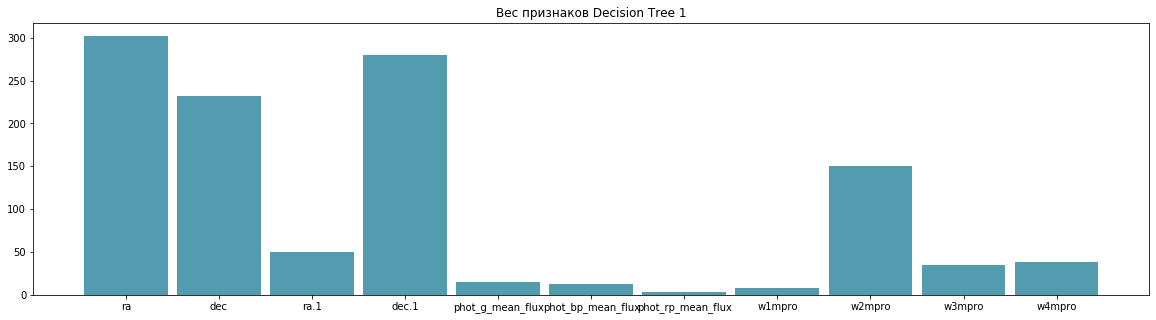

In [181]:
model2 = lgb.LGBMClassifier(n_estimators=100, silent=True,  num_leaves = 25, learning_rate = 0.03, random_state = 27)
model2 = model2.fit(xx, yy1)


res = model2.predict(tr2)

print('accuracy_score: ', accuracy_score(yx, res))
print('precision_score: ', precision_score(yx, res))
print('recall_score: ', recall_score(yx, res))
print('f1_score: ', f1_score(yx, res))
print()

weight_f = model2.feature_importances_
print(weight_f)

print('------------------------------------')
res = model2.predict(tr3)

print('accuracy_score: ', accuracy_score(yz, res))
print('precision_score: ', precision_score(yz, res))
print('recall_score: ', recall_score(yz, res))
print('f1_score: ', f1_score(yz, res))
print()

weight_f = model2.feature_importances_
print(weight_f)

print('------------------------------------')

res = model2.predict(tr4)

print('accuracy_score: ', accuracy_score(yf, res))
print('precision_score: ', precision_score(yf, res))
print('recall_score: ', recall_score(yf, res))
print('f1_score: ', f1_score(yf, res))
print()

barplot(col_lab, weight_f, '', '', '', 'Вес признаков Decision Tree 1', 20, 5)

In [182]:
dt2 = DecisionTreeClassifier()
df2 = dt2.fit(xx, yy1)
res = dt2.predict(X_val)

print('accuracy_score: ', accuracy_score(y_val, res))
print('precision_score: ', precision_score(y_val, res))
print('recall_score: ', recall_score(y_val, res))
print('f1_score: ', f1_score(y_val, res))
print()

print(dt2.n_features_)
weight_f = dt2.feature_importances_
print(weight_f)

print('------------------------------------')
res = dt2.predict(tr2)

print('accuracy_score: ', accuracy_score(yx, res))
print('precision_score: ', precision_score(yx, res))
print('recall_score: ', recall_score(yx, res))
print('f1_score: ', f1_score(yx, res))
print()

print(dt2.n_features_)
weight_f = dt2.feature_importances_
print(weight_f)

print('------------------------------------')
res = dt2.predict(tr3)

print('accuracy_score: ', accuracy_score(yz, res))
print('precision_score: ', precision_score(yz, res))
print('recall_score: ', recall_score(yz, res))
print('f1_score: ', f1_score(yz, res))
print()

print(dt2.n_features_)
weight_f = dt2.feature_importances_
print(weight_f)

print('------------------------------------')

res = dt2.predict(tr4)

print('accuracy_score: ', accuracy_score(yf, res))
print('precision_score: ', precision_score(yf, res))
print('recall_score: ', recall_score(yf, res))
print('f1_score: ', f1_score(yf, res))
print()



accuracy_score:  0.9990272373540856
precision_score:  1.0
recall_score:  0.9975961538461539
f1_score:  0.9987966305655837

11
[0.51427511 0.2218644  0.00543607 0.24854022 0.         0.
 0.         0.         0.         0.00436744 0.00551676]
------------------------------------
accuracy_score:  0.8594208980276962
precision_score:  0.9895729890764647
recall_score:  0.7543527630582891
f1_score:  0.8560996563573883

11
[0.51427511 0.2218644  0.00543607 0.24854022 0.         0.
 0.         0.         0.         0.00436744 0.00551676]
------------------------------------
accuracy_score:  1.0
precision_score:  1.0
recall_score:  1.0
f1_score:  1.0

11
[0.51427511 0.2218644  0.00543607 0.24854022 0.         0.
 0.         0.         0.         0.00436744 0.00551676]
------------------------------------
accuracy_score:  0.9519077901430842
precision_score:  1.0
recall_score:  0.7477853048462741
f1_score:  0.8556946929039952



In [183]:
dt2 = DecisionTreeClassifier()
df2 = dt2.fit(xx, yy1)
res = dt2.predict(X_val)

print('accuracy_score: ', accuracy_score(y_val, res))
print('precision_score: ', precision_score(y_val, res))
print('recall_score: ', recall_score(y_val, res))
print('f1_score: ', f1_score(y_val, res))
print()

print(dt2.n_features_)
weight_f = dt2.feature_importances_
print(weight_f)

print('------------------------------------')
res = dt2.predict(tr2)

print('accuracy_score: ', accuracy_score(yx, res))
print('precision_score: ', precision_score(yx, res))
print('recall_score: ', recall_score(yx, res))
print('f1_score: ', f1_score(yx, res))
print()

print(dt2.n_features_)
weight_f = dt2.feature_importances_
print(weight_f)

print('------------------------------------')
res = dt2.predict(tr3)

print('accuracy_score: ', accuracy_score(yz, res))
print('precision_score: ', precision_score(yz, res))
print('recall_score: ', recall_score(yz, res))
print('f1_score: ', f1_score(yz, res))
print()

print(dt2.n_features_)
weight_f = dt2.feature_importances_
print(weight_f)

print('------------------------------------')

res = dt2.predict(tr4)

print('accuracy_score: ', accuracy_score(yf, res))
print('precision_score: ', precision_score(yf, res))
print('recall_score: ', recall_score(yf, res))
print('f1_score: ', f1_score(yf, res))
print()

accuracy_score:  0.9990272373540856
precision_score:  1.0
recall_score:  0.9975961538461539
f1_score:  0.9987966305655837

11
[0.51427511 0.22841556 0.01095283 0.24198907 0.         0.
 0.         0.         0.         0.00436744 0.        ]
------------------------------------
accuracy_score:  0.8594208980276962
precision_score:  0.9895729890764647
recall_score:  0.7543527630582891
f1_score:  0.8560996563573883

11
[0.51427511 0.22841556 0.01095283 0.24198907 0.         0.
 0.         0.         0.         0.00436744 0.        ]
------------------------------------
accuracy_score:  1.0
precision_score:  1.0
recall_score:  1.0
f1_score:  1.0

11
[0.51427511 0.22841556 0.01095283 0.24198907 0.         0.
 0.         0.         0.         0.00436744 0.        ]
------------------------------------
accuracy_score:  0.9522058823529411
precision_score:  1.0
recall_score:  0.7493486190724336
f1_score:  0.8567173071194518



In [359]:
model2  = SVC(verbose = True, kernel = 'linear', tol = 0.0001,gamma = 'auto', random_state = 24)
model2 = model2.fit(xx, yy1)
res_lgb = model2.predict(X_val)
res = res_lgb

print('accuracy_score: ', accuracy_score(y_val, res))
print('precision_score: ', precision_score(y_val, res))
print('recall_score: ', recall_score(y_val, res))
print('f1_score: ', f1_score(y_val, res))
print()


print('------------------------------------')
res = model2.predict(tr2)

print('accuracy_score: ', accuracy_score(yx, res))
print('precision_score: ', precision_score(yx, res))
print('recall_score: ', recall_score(yx, res))
print('f1_score: ', f1_score(yx, res))
print()


print('------------------------------------')
res = model2.predict(tr3)

print('accuracy_score: ', accuracy_score(yz, res))
print('precision_score: ', precision_score(yz, res))
print('recall_score: ', recall_score(yz, res))
print('f1_score: ', f1_score(yz, res))
print()

print('------------------------------------')

res = model2.predict(tr4)

print('accuracy_score: ', accuracy_score(yf, res))
print('precision_score: ', precision_score(yf, res))
print('recall_score: ', recall_score(yf, res))
print('f1_score: ', f1_score(yf, res))
print()

[LibSVM]accuracy_score:  0.9163424124513618
precision_score:  0.9910714285714286
recall_score:  0.8004807692307693
f1_score:  0.8856382978723404

------------------------------------
accuracy_score:  0.741502308015107
precision_score:  0.8589613034623218
recall_score:  0.6385314155942468
f1_score:  0.7325227963525835

------------------------------------
accuracy_score:  0.7902955939765756
precision_score:  0.9159318048206937
recall_score:  0.5337444330250085
f1_score:  0.6744588744588744

------------------------------------
accuracy_score:  0.9529014308426074
precision_score:  0.9446153846153846
recall_score:  0.7998957790515894
f1_score:  0.8662528216704289



In [ ]:
tr31 = euclid_distance(tr31)
#можем посмотреть таким образом пары,которые были неверно распознаны (в данном случае какие несопоставимые пары были отмечены одним объектом)
tr31['match'] = [1 if x < 0.01 else 0 for x in dd['eucl']]
tr31.sort_values(by = ['matched'], ascending = False).sort_values(by = ['match'], ascending = True).head()

Другой тренировочный набор (для сравнения)

In [ ]:
x11 = no_data1[no_data1['eucl'] < 0.1].sample(frac = 0.065) #0.1, 0.064
x22 = data1[data1['eucl'] > 0.001].sample(frac = 0.32) #0.5, 0.32


x = pd.concat([x11, x22], axis = 0)
vvx = x.copy()
vv = len(x)

x11 = no_data1[no_data1['eucl'] > 1].sample(frac = 0.036) #0.04, 0.036
x22 = data1[data1['eucl'] < 0.01].sample(frac = 0.028)#0.028, 0.0192

x = pd.concat([x, x11, x22], axis = 0)

In [ ]:
x11 = no_data1[no_data1['eucl'] < 0.1]
x11 = x11[x11['dec'] < -70]
x11 = x11[x11['dec.1'] < -60].sample(frac = 0.09) #0.1, 0.064

x22 = data1[data1['eucl'] > 0.001]
x22 = x22[x22['dec'] < -60]
x22 = x22[x22['dec.1'] < -50].sample(frac = 0.4) #0.5, 0.32

x = pd.concat([x11, x22], axis = 0)
vvx = x.copy()
vv = len(x)

x11 = no_data1[no_data1['eucl'] > 1]
x11 = x11[x11['dec'] < -60]
x11 = x11[x11['dec.1'] < -50].sample(frac = 0.17) #0.04, 0.036

x22 = data1[data1['eucl'] < 0.01]
x22 = x22[x22['dec'] < -70]
x22 = x22[x22['dec.1'] < -60].sample(frac = 0.1)#0.028, 0.0192

x = pd.concat([x, x11, x22], axis = 0)

In [313]:
print(len(x))

808


In [314]:
#есть ли примеры, когда сопоставимые пары больше заданного порога эпсилон
data1[data1['eucl'] > 0.01].sort_values(by = ['eucl'], ascending = False).head()


,eucl,ra,dec,ra.1,dec.1,phot_g_mean_flux,phot_bp_mean_flux,phot_rp_mean_flux,w1mpro,w2mpro,w3mpro,w4mpro,matched
29,359.999760,359.999831,50.308983,0.000071,50.309007,705.206406,315.993344,578.048514,16.507,17.215,13.122,9.301,1
36,359.997103,359.998220,-84.023799,0.001116,-84.023793,122.091809,45.751963,112.752069,17.611,17.201,13.208,9.347,1
905,0.014826,0.011893,-89.857007,0.026719,-89.856993,749.786519,229.951549,840.612913,15.091,15.122,12.676,8.836,1
499,0.013570,0.000868,-88.294694,0.014437,-88.294567,80.682856,60.290229,116.256966,17.998,17.864,13.061,9.435,1
758,0.013437,0.036119,-89.448887,0.022682,-89.448891,405.679606,123.662675,443.888051,15.761,15.702,12.732,9.456,1


In [315]:
no_data1[no_data1['eucl'] < 0.01].sort_values(by = ['eucl']).head()

,eucl,ra,dec,ra.1,dec.1,phot_g_mean_flux,phot_bp_mean_flux,phot_rp_mean_flux,w1mpro,w2mpro,w3mpro,w4mpro,matched
399,0.002663,17.667137,-73.007828,17.668271,-73.005419,278.434553,163.695615,236.038185,13.722,13.817,12.875,9.32,0
653,0.002725,17.667137,-73.007828,17.666839,-73.010537,510.883366,456.214589,252.581683,13.722,13.817,12.875,9.32,0
328,0.003715,17.667137,-73.007828,17.669419,-73.010761,219.167999,207.685595,157.020166,13.722,13.817,12.875,9.32,0
648,0.006156,17.667137,-73.007828,17.661920,-73.011095,165.911982,192.368498,115.975896,13.722,13.817,12.875,9.32,0


In [316]:
#соотношение плохих примеров
print(vv/len(x))

0.1311881188118812


In [ ]:
#Можем сравнить разбиение разных частей, созданных наборов по отдельным признакам

plot_histogram2(x11['ra'], x33['ra'])

In [317]:
yy = x['matched']
x = x.drop(columns=['matched', 'eucl'])

accuracy_score:  0.9961089494163424
precision_score:  1.0
recall_score:  0.9903846153846154
f1_score:  0.9951690821256038

11
[0.26514883 0.29687833 0.11930678 0.22509081 0.         0.
 0.         0.06600701 0.01420182 0.01336642 0.        ]
------------------------------------
accuracy_score:  0.8804028535459505
precision_score:  0.9966442953020134
recall_score:  0.7869038607115821
f1_score:  0.8794416243654821

11
[0.26514883 0.29687833 0.11930678 0.22509081 0.         0.
 0.         0.06600701 0.01420182 0.01336642 0.        ]
------------------------------------
accuracy_score:  0.9962353597322923
precision_score:  1.0
recall_score:  0.9907502569373073
f1_score:  0.9953536396489417

11
[0.26514883 0.29687833 0.11930678 0.22509081 0.         0.
 0.         0.06600701 0.01420182 0.01336642 0.        ]
------------------------------------
accuracy_score:  0.9876788553259142
precision_score:  1.0
recall_score:  0.9353830119854091
f1_score:  0.9666128163704901



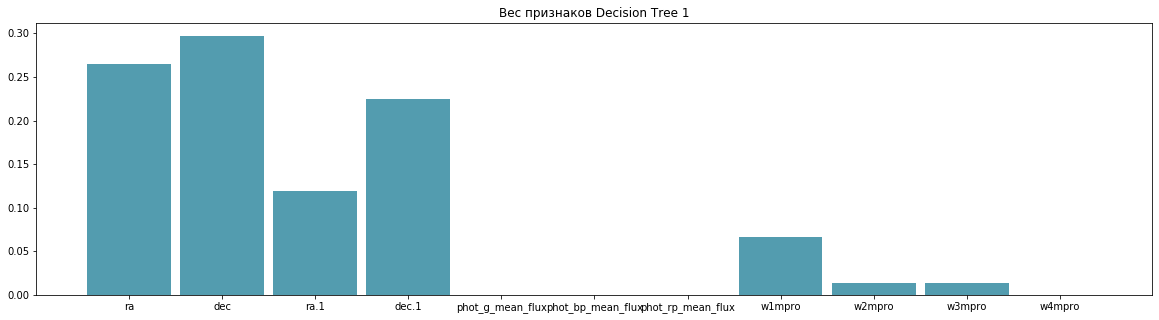

In [322]:
dt1 = DecisionTreeClassifier( criterion='gini', splitter='random', random_state = 17)
dt1 = dt1.fit(x, yy)
res = dt1.predict(X_val)

print('accuracy_score: ', accuracy_score(y_val, res))
print('precision_score: ', precision_score(y_val, res))
print('recall_score: ', recall_score(y_val, res))
print('f1_score: ', f1_score(y_val, res))
print()

print(dt1.n_features_)
weight_f = dt1.feature_importances_
print(weight_f)

print('------------------------------------')
res = dt1.predict(tr2)

print('accuracy_score: ', accuracy_score(yx, res))
print('precision_score: ', precision_score(yx, res))
print('recall_score: ', recall_score(yx, res))
print('f1_score: ', f1_score(yx, res))
print()

print(dt1.n_features_)
weight_f = dt1.feature_importances_
print(weight_f)

print('------------------------------------')
res = dt1.predict(tr3)

print('accuracy_score: ', accuracy_score(yz, res))
print('precision_score: ', precision_score(yz, res))
print('recall_score: ', recall_score(yz, res))
print('f1_score: ', f1_score(yz, res))
print()

print(dt1.n_features_)
weight_f = dt1.feature_importances_
print(weight_f)

print('------------------------------------')

res = dt1.predict(tr4)

print('accuracy_score: ', accuracy_score(yf, res))
print('precision_score: ', precision_score(yf, res))
print('recall_score: ', recall_score(yf, res))
print('f1_score: ', f1_score(yf, res))
print()

col_lab = []
for i in tr2.columns:
    col_lab.append(i)

barplot(col_lab, weight_f, '', '', '', 'Вес признаков Decision Tree 1', 20, 5)

accuracy_score:  0.8804028535459505
precision_score:  0.9966442953020134
recall_score:  0.7869038607115821
f1_score:  0.8794416243654821

accuracy_score:  0.8619387326898867
precision_score:  0.9984924623115577
recall_score:  0.7520817562452687
f1_score:  0.8579447322970638

4766
4766
4766


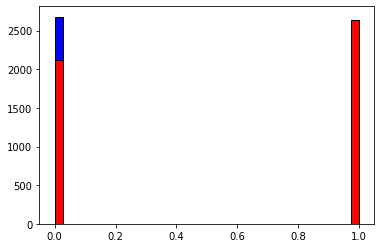

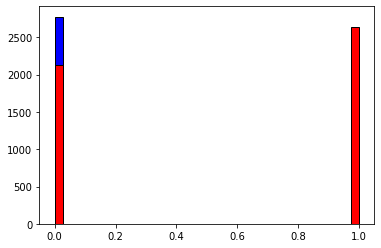

In [323]:
res1 = dt1.predict(tr2)
tr22 = tr2.copy()
dd = euclid_distance(tr22)
res2 =  [1 if x < 0.01 else 0 for x in dd['eucl']]

print('accuracy_score: ', accuracy_score(yx, res1))
print('precision_score: ', precision_score(yx, res1))
print('recall_score: ', recall_score(yx, res1))
print('f1_score: ', f1_score(yx, res1))
print()

print('accuracy_score: ', accuracy_score(yx, res2))
print('precision_score: ', precision_score(yx, res2))
print('recall_score: ', recall_score(yx, res2))
print('f1_score: ', f1_score(yx, res2))
print()

print(len(res1))
print(len(res2))
print(len(yx))


plot_histogram2(res1, yx)
plot_histogram2(res2, yx)

accuracy_score:  0.8804028535459505
precision_score:  0.9966442953020134
recall_score:  0.7869038607115821
f1_score:  0.8794416243654821

accuracy_score:  0.8619387326898867
precision_score:  0.9984924623115577
recall_score:  0.7520817562452687
f1_score:  0.8579447322970638

4766
4766
4766


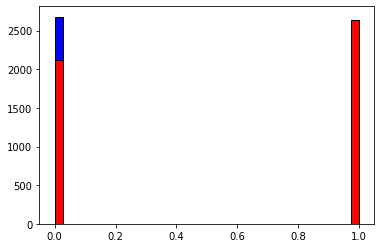

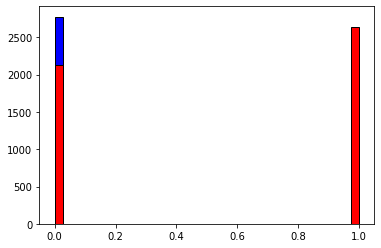

In [324]:
res1 = dt1.predict(tr2)
tr22 = tr2.copy()
dd = euclid_distance(tr22)
res2 =  [1 if x < 0.01 else 0 for x in dd['eucl']]

print('accuracy_score: ', accuracy_score(yx, res1))
print('precision_score: ', precision_score(yx, res1))
print('recall_score: ', recall_score(yx, res1))
print('f1_score: ', f1_score(yx, res1))
print()

print('accuracy_score: ', accuracy_score(yx, res2))
print('precision_score: ', precision_score(yx, res2))
print('recall_score: ', recall_score(yx, res2))
print('f1_score: ', f1_score(yx, res2))
print()

print(len(res1))
print(len(res2))
print(len(yx))


plot_histogram2(res1, yx)
plot_histogram2(res2, yx)

[11:57:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { eval } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


accuracy_score:  0.9980544747081712
precision_score:  1.0
recall_score:  0.9951923076923077
f1_score:  0.9975903614457832

[0.01912725 0.39596242 0.0088317  0.43546847 0.         0.00811838
 0.00394756 0.00717185 0.01771156 0.09940184 0.00425888]
------------------------------------
accuracy_score:  0.9032731850608476
precision_score:  0.9918809201623816
recall_score:  0.8323239969719909
f1_score:  0.9051245112162998

[0.01912725 0.39596242 0.0088317  0.43546847 0.         0.00811838
 0.00394756 0.00717185 0.01771156 0.09940184 0.00425888]
------------------------------------
accuracy_score:  0.9998605688789738

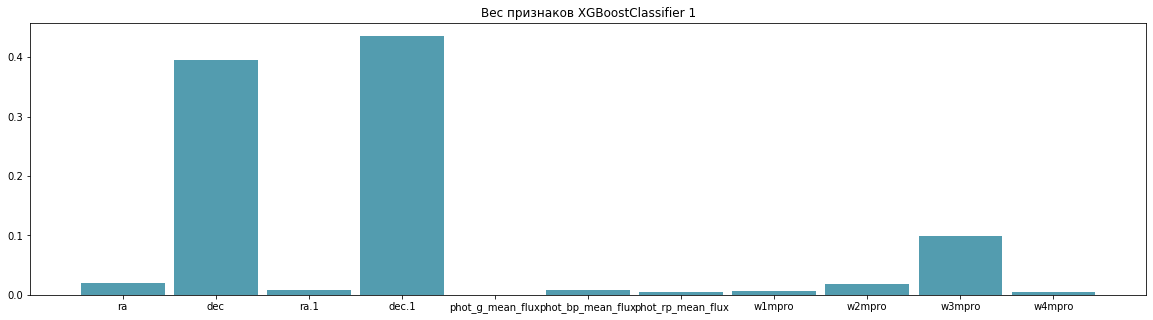

In [329]:
modelx = xgb.XGBClassifier(random_state = 42, eval = 'mse')
modelx = modelx.fit(x, yy)
res_xgb = modelx.predict(X_val)
res = res_xgb

print('accuracy_score: ', accuracy_score(y_val, res))
print('precision_score: ', precision_score(y_val, res))
print('recall_score: ', recall_score(y_val, res))
print('f1_score: ', f1_score(y_val, res))
print()

weight_f = modelx.feature_importances_
print(weight_f)

print('------------------------------------')
res = modelx.predict(tr2)

print('accuracy_score: ', accuracy_score(yx, res))
print('precision_score: ', precision_score(yx, res))
print('recall_score: ', recall_score(yx, res))
print('f1_score: ', f1_score(yx, res))
print()

weight_f = modelx.feature_importances_
print(weight_f)

print('------------------------------------')
res = modelx.predict(tr3)

print('accuracy_score: ', accuracy_score(yz, res))
print('precision_score: ', precision_score(yz, res))
print('recall_score: ', recall_score(yz, res))
print('f1_score: ', f1_score(yz, res))
print()

weight_f = modelx.feature_importances_
print(weight_f)

print('------------------------------------')

res = modelx.predict(tr4)

print('accuracy_score: ', accuracy_score(yf, res))
print('precision_score: ', precision_score(yf, res))
print('recall_score: ', recall_score(yf, res))
print('f1_score: ', f1_score(yf, res))
print()

weight_f = weight_f + 0.0001
print(weight_f)
print(len(weight_f))
print(x.columns)
col_lab = x.columns
print(len(col_lab))
barplot(col_lab, weight_f, '', '', '', 'Вес признаков XGBoostClassifier 1', 20, 5)

7172
7172
4766


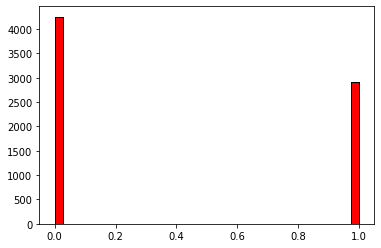

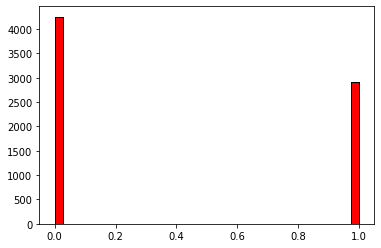

In [330]:
#сравнение работы модели и алгоритма эпсилон-окрестности
res1 = modelx.predict(tr3)
tr33 = tr3.copy()
dd = euclid_distance(tr33)
res2 =  [1 if x < 0.01 else 0 for x in dd['eucl']]

print(len(res1))
print(len(res2))
print(len(yx))


plot_histogram2(res1, yz)
plot_histogram2(res2, yz)

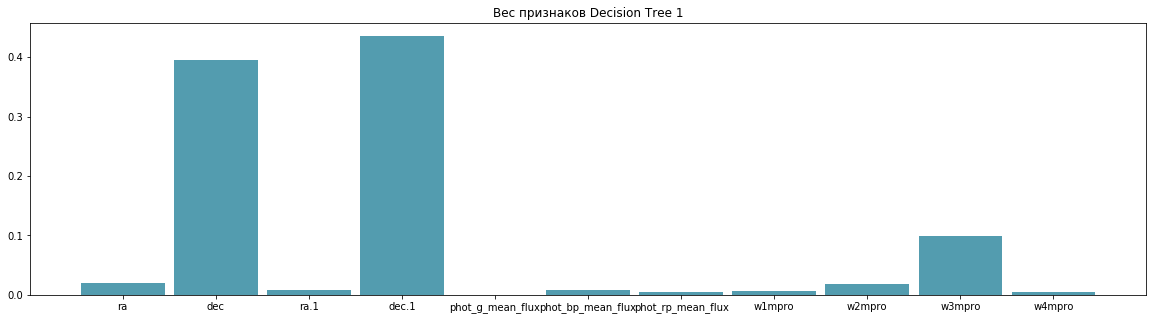

In [331]:
col_lab = []
for i in tr2.columns:
    col_lab.append(i)

barplot(col_lab, weight_f, '', '', '', 'Вес признаков Decision Tree 1', 20, 5)

In [ ]:
model2 = lgb.LGBMClassifier(n_estimators=100, silent=True,  num_leaves = 20, learning_rate = 0.05, random_state = 27)
model2 = model2.fit(x, yy)


res = model2.predict(tr2)

print('accuracy_score: ', accuracy_score(yx, res))
print('precision_score: ', precision_score(yx, res))
print('recall_score: ', recall_score(yx, res))
print('f1_score: ', f1_score(yx, res))
print()

weight_f = model2.feature_importances_
print(weight_f)

print('------------------------------------')
res = model2.predict(tr3)

print('accuracy_score: ', accuracy_score(yz, res))
print('precision_score: ', precision_score(yz, res))
print('recall_score: ', recall_score(yz, res))
print('f1_score: ', f1_score(yz, res))
print()

weight_f = model2.feature_importances_
print(weight_f)

print('------------------------------------')

res = model2.predict(tr4)

print('accuracy_score: ', accuracy_score(yf, res))
print('precision_score: ', precision_score(yf, res))
print('recall_score: ', recall_score(yf, res))
print('f1_score: ', f1_score(yf, res))
print()

barplot(col_lab, weight_f, '', '', '', 'Вес признаков LightGBM', 20, 5)

In [ ]:
model2  = KNeighborsClassifier(n_neighbors=7, weights = 'distance', algorithm='ball_tree', leaf_size=5)
model2 = model2.fit(x, yy)
res_lgb = model2.predict(X_val)
res = res_lgb

print('accuracy_score: ', accuracy_score(y_val, res))
print('precision_score: ', precision_score(y_val, res))
print('recall_score: ', recall_score(y_val, res))
print('f1_score: ', f1_score(y_val, res))
print()


print('------------------------------------')
res = model2.predict(tr2)

print('accuracy_score: ', accuracy_score(yx, res))
print('precision_score: ', precision_score(yx, res))
print('recall_score: ', recall_score(yx, res))
print('f1_score: ', f1_score(yx, res))
print()


print('------------------------------------')
res = model2.predict(tr3)

print('accuracy_score: ', accuracy_score(yz, res))
print('precision_score: ', precision_score(yz, res))
print('recall_score: ', recall_score(yz, res))
print('f1_score: ', f1_score(yz, res))
print()

print('------------------------------------')

res = model2.predict(tr4)

print('accuracy_score: ', accuracy_score(yf, res))
print('precision_score: ', precision_score(yf, res))
print('recall_score: ', recall_score(yf, res))
print('f1_score: ', f1_score(yf, res))
print()

In [ ]:
model2  = SVC(verbose = True, kernel = 'linear', tol = 0.0001,gamma = 'auto', random_state = 24)
model2 = model2.fit(x, yy)
res_lgb = model2.predict(X_val)
res = res_lgb

print('accuracy_score: ', accuracy_score(y_val, res))
print('precision_score: ', precision_score(y_val, res))
print('recall_score: ', recall_score(y_val, res))
print('f1_score: ', f1_score(y_val, res))
print()


print('------------------------------------')
res = model2.predict(tr2)

print('accuracy_score: ', accuracy_score(yx, res))
print('precision_score: ', precision_score(yx, res))
print('recall_score: ', recall_score(yx, res))
print('f1_score: ', f1_score(yx, res))
print()


print('------------------------------------')
res = model2.predict(tr3)

print('accuracy_score: ', accuracy_score(yz, res))
print('precision_score: ', precision_score(yz, res))
print('recall_score: ', recall_score(yz, res))
print('f1_score: ', f1_score(yz, res))
print()

print('------------------------------------')

res = model2.predict(tr4)

print('accuracy_score: ', accuracy_score(yf, res))
print('precision_score: ', precision_score(yf, res))
print('recall_score: ', recall_score(yf, res))
print('f1_score: ', f1_score(yf, res))
print()

In [ ]:
m = len(x.columns)
p = len(yy.drop_duplicates())
print(m)
print(p)
mlp = MLPClassifier(hidden_layer_sizes=((m+p)*150, ), solver = 'adam', learning_rate_init=0.01, max_iter=200, tol = 0.00001, verbose = False)
mpl = mlp.fit(x, yy)
res_mlp = mpl.predict(X_val)
res = res_mlp

print('accuracy_score: ', accuracy_score(y_val, res))
print('precision_score: ', precision_score(y_val, res))
print('recall_score: ', recall_score(y_val, res))
print('f1_score: ', f1_score(y_val, res))
print()


print('------------------------------------')
res = mpl.predict(tr2)

print('accuracy_score: ', accuracy_score(yx, res))
print('precision_score: ', precision_score(yx, res))
print('recall_score: ', recall_score(yx, res))
print('f1_score: ', f1_score(yx, res))
print()


print('------------------------------------')
res = mpl.predict(tr3)

print('accuracy_score: ', accuracy_score(yz, res))
print('precision_score: ', precision_score(yz, res))
print('recall_score: ', recall_score(yz, res))
print('f1_score: ', f1_score(yz, res))
print()

print('------------------------------------')

res = mpl.predict(tr4)

print('accuracy_score: ', accuracy_score(yf, res))
print('precision_score: ', precision_score(yf, res))
print('recall_score: ', recall_score(yf, res))
print('f1_score: ', f1_score(yf, res))
print()

In [ ]:
dd = euclid_distance(tr2.copy())
dd['matched'] = yx

dd['match'] =  [1 if x < 0.1 else 0 for x in dd['eucl']] #0.01-0.001
print('accuracy_score: ', accuracy_score(dd['matched'], dd['match']))
print('precision_score: ', precision_score(dd['matched'], dd['match']))
print('recall_score: ', recall_score(dd['matched'], dd['match']))
print('f1_score: ', f1_score(dd['matched'], dd['match']))
print()